# Introduction to Basic Functionality of NTM
_**Finding Topics in Synthetic Document Data with the Neural Topic Model**_

---

---

# Contents
***

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
1. [Extensions](#Extensions)

# Introduction
***

Amazon SageMaker NTM (Neural Topic Model) is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. NTM is most commonly used to discover a user-specified number of topics shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified up front, and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics.

In this notebook we will use the Amazon SageMaker NTM algorithm to train a model on some example synthetic data. We will then use this model to classify (perform inference on) the data. The main goals of this notebook are to,

* learn how to obtain and store data for use in Amazon SageMaker,
* create an AWS SageMaker training job on a data set to produce a NTM model,
* use the model to perform inference with an Amazon SageMaker endpoint.

# Setup
***

_This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
# Define IAM role
import sagemaker
import boto3
import re
from sagemaker import get_execution_role

sess = sagemaker.Session()
# bucket = sess.default_bucket()
bucket = 'bucket-sushant'
prefix = "topic_modelling/ntm_demo"
role = get_execution_role()
region = boto3.Session().region_name


Next we download the synthetic data generation module if it does not exist.

In [5]:
from os import path

data_generation_file = "generate_example_data.py"  # Synthetic data generation module

# Uncomment if you don't have the repository cloned with the generate_example_data.py file
# if not path.exists(data_generation_file):
#    tools_bucket = f"jumpstart-cache-prod-{region}"  # Bucket containing the data generation module.
#    tools_prefix = "1p-algorithms-assets/ntm"  # Prefix for the data generation module
#    s3 = boto3.client("s3")
#    s3.download_file(tools_bucket, f"{tools_prefix}/{data_generation_file}", data_generation_file)

Next we'll import the libraries we'll need throughout the remainder of the notebook.

In [6]:
import numpy as np
from generate_example_data import generate_griffiths_data, plot_topic_data
import io
import os
import time
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import scipy
import sagemaker.amazon.common as smac
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Data
***

We generate some example synthetic document data. For the purposes of this notebook we will omit the details of this process. All we need to know is that each piece of data, commonly called a "document", is a vector of integers representing "word counts" within the document. In this particular example there are a total of 25 words in the "vocabulary".

In [7]:
# generate the sample data
num_documents = 5000
num_topics = 5
vocabulary_size = 25
known_alpha, known_beta, documents, topic_mixtures = generate_griffiths_data(
    num_documents=num_documents, num_topics=num_topics, vocabulary_size=vocabulary_size
)

# separate the generated data into training and tests subsets
num_documents_training = int(0.8 * num_documents)
num_documents_test = num_documents - num_documents_training

documents_training = documents[:num_documents_training]
documents_test = documents[num_documents_training:]

topic_mixtures_training = topic_mixtures[:num_documents_training]
topic_mixtures_test = topic_mixtures[num_documents_training:]

data_training = (documents_training, np.zeros(num_documents_training))
data_test = (documents_test, np.zeros(num_documents_test))

## Inspect Example Data

*What does the example data actually look like?* Below we print an example document as well as its corresponding *known* topic mixture. Later, when we perform inference on the training data set we will compare the inferred topic mixture to this known one.

As we can see, each document is a vector of word counts from the 25-word vocabulary

In [11]:
known_alpha, known_beta, documents, topic_mixtures

(array([0.2, 0.2, 0.2, 0.2, 0.2]),
 array([[0.22310042, 0.        , 0.        , 0.        , 0.        ,
         0.19553654, 0.        , 0.        , 0.        , 0.        ,
         0.22529196, 0.        , 0.        , 0.        , 0.        ,
         0.17010336, 0.        , 0.        , 0.        , 0.        ,
         0.18596772, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.19990168, 0.        , 0.        , 0.        ,
         0.        , 0.20690403, 0.        , 0.        , 0.        ,
         0.        , 0.19424878, 0.        , 0.        , 0.        ,
         0.        , 0.20055947, 0.        , 0.        , 0.        ,
         0.        , 0.19838606, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.2219406 , 0.        , 0.        ,
         0.        , 0.        , 0.18786895, 0.        , 0.        ,
         0.        , 0.        , 0.14680112, 0.        , 0.        ,
         0.        , 0.        , 0.20461544, 0.        , 0.       

In [14]:
type(documents), type(topic_mixtures)

(numpy.ndarray, numpy.ndarray)

In [15]:
documents.shape, topic_mixtures.shape

((5000, 25), (5000, 5))

In [8]:
print(f"First training document = {documents[0]}")
print(f"\nVocabulary size = {vocabulary_size}")

First training document = [ 0.  4.  0. 27.  0.  1.  1.  0. 21.  0.  0.  1.  0. 37.  0.  0.  1.  0.
 21.  0.  0.  3.  0. 24.  0.]

Vocabulary size = 25


In [12]:
np.set_printoptions(precision=4, suppress=True)

print(f"Known topic mixture of first training document = {topic_mixtures_training[0]}")
print(f"\nNumber of topics = {num_topics}")

Known topic mixture of first training document = [0.0091 0.095  0.0007 0.8951 0.    ]

Number of topics = 5


Because we are visual creatures, let's try plotting the documents. In the below plots, each pixel of a document represents a word. The greyscale intensity is a measure of how frequently that word occurs. Below we plot the first tes documents of the training set reshaped into 5x5 pixel grids.

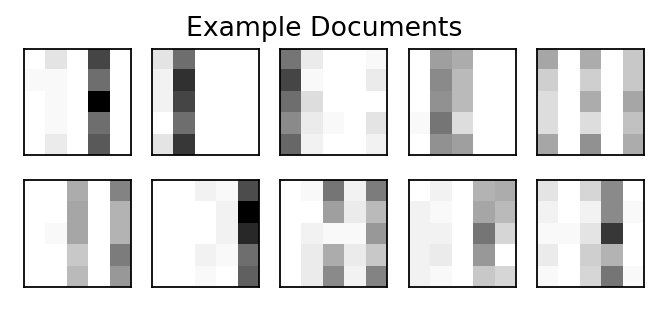

In [13]:
%matplotlib inline

fig = plot_topic_data(documents_training[:10], nrows=2, ncols=5, cmap="gray_r", with_colorbar=False)
fig.suptitle("Example Documents")
fig.set_dpi(160)

## Store Data on S3

A SageMaker training job needs access to training data stored in an S3 bucket. Although training can accept data of various formats recordIO wrapped protobuf is most performant.

_Note, since NTM is an unsupervised learning algorithm, we simple put 0 in for all label values._

In [ ]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, data_training[0].astype("float32"))
buf.seek(0)

key = "ntm.data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"

# Training

***

Once the data is preprocessed and available in a recommended format the next step is to train our model on the data. There are number of parameters required by the NTM algorithm to configure the model and define the computational environment in which training will take place.  The first of these is to point to a container image which holds the algorithms training and hosting code.

In [ ]:
from sagemaker import image_uris

container = image_uris.retrieve(region=boto3.Session().region_name, framework="ntm")

An NTM model uses the following hyperparameters:

* **`num_topics`** - The number of topics or categories in the NTM model. This has been pre-defined in our synthetic data to be 5.

* **`feature_dim`** - The size of the *"vocabulary"*, in topic modeling parlance. In this case, this has been set to 25 by `generate_griffiths_data()`.

In addition to these NTM model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role.

In [ ]:
sess = sagemaker.Session()

ntm = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=sess,
)
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocabulary_size)

ntm.fit({"train": s3_train_data})

# Inference

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

This is simplified by the deploy function provided by the Amazon SageMaker Python SDK.

In [ ]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

## Perform Inference

With this real-time endpoint at our fingertips we can finally perform inference on our training and test data.  We should first discuss the meaning of the SageMaker NTM inference output.

For each document we wish to compute its corresponding `topic_weights`. Each set of topic weights is a probability distribution over the number of topics, which is 5 in this example. Of the 5 topics discovered during NTM training each element of the topic weights is the proportion to which the input document is represented by the corresponding topic.

For example, if the topic weights of an input document $\mathbf{w}$ is,

$$\theta = \left[ 0.3, 0.2, 0, 0.5, 0 \right]$$

then $\mathbf{w}$ is 30% generated from Topic #1, 20% from Topic #2, and 50% from Topic #4. Below, we compute the topic mixtures for the first ten traning documents.

First, we setup our serializes and deserializers which allow us to convert NumPy arrays to CSV strings which we can pass into our HTTP POST request to our hosted endpoint.

In [ ]:
ntm_predictor.serializer = CSVSerializer()
ntm_predictor.deserializer = JSONDeserializer()

Now, let's check results for a small sample of records.

In [ ]:
results = ntm_predictor.predict(documents_training[:10], initial_args={"ContentType": "text/csv"})
print(results)

We can see the output format of SageMaker NTM inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    ...
  ]
}
```

We extract the topic weights, themselves, corresponding to each of the input documents.

In [ ]:
predictions = np.array([prediction["topic_weights"] for prediction in results["predictions"]])

print(predictions)

If you decide to compare these results to the known topic weights generated above keep in mind that SageMaker NTM discovers topics in no particular order. That is, the approximate topic mixtures computed above may be (approximate) permutations of the known topic mixtures corresponding to the same documents.

In [ ]:
print(topic_mixtures_training[0])  # known topic mixture
print(predictions[0])  # computed topic mixture

With that said, let's look at how our learned topic weights map to known topic mixtures for the entire training set.  Because NTM inherently creates a soft clustering (meaning that documents can sometimes belong partially to multiple topics), we'll evaluate correlation of topic weights.  This gives us a more relevant picture than just selecting the single topic for each document that happens to have the highest probability.

To do this, we'll first need to generate predictions for all of our training data.  Because our endpoint has a ~6MB per POST request limit, let's break the training data up into mini-batches and loop over them, creating a full dataset of predictions.

In [ ]:
def predict_batches(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        results = ntm_predictor.predict(array, initial_args={"ContentType": "text/csv"})
        predictions += [r["topic_weights"] for r in results["predictions"]]
    return np.array(predictions)

In [ ]:
predictions = predict_batches(documents_training)

Now we'll look at how the actual and predicted topics correlate.

In [ ]:
data = pd.DataFrame(
    np.concatenate([topic_mixtures_training, predictions], axis=1),
    columns=[f"actual_{i}" for i in range(5)] + [f"predictions_{i}" for i in range(5)],
)
display(data.corr())
pd.plotting.scatter_matrix(
    pd.DataFrame(np.concatenate([topic_mixtures_training, predictions], axis=1)), figsize=(12, 12)
)
plt.show()

As we can see:
- The upper left quadrant of 5 * 5 cells illustrates that the data are synthetic as the correlations are all slightly negative, but too perfectly triangular to occur naturally.
- The upper right quadrant, which tells us about our model fit, shows some similarities, with many correlations having very near triangular shape, and negative correlations of a similar magnitude.
  - Notice, actual topic #2 maps to predicted topic #2.  Similarly actual topic #3 maps to predicted topic #3, and #4 to #4.  However, there's a slight bit of uncertainty in topics #0 and #1.  Actual topic #0 appears to map to predicted topic #1, but actual topic #1 also correlates most highly with predicted topic #1.  This is not unexpected given that we're working with manufactured data and unsupervised algorithms.  The important part is that NTM is picking up aggregate structure well and with increased tuning of hyperparameters may fit the data even more closely.

_Note, specific results may differ due to randomized steps in the data generation and algorithm, but the general story should remain unchanged._

## Stop / Close the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To restart the endpoint you can follow the code above using the same `endpoint_name` we created or you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [ ]:
ntm_predictor.delete_model()
ntm_predictor.delete_endpoint()

# Extensions

***

This notebook was a basic introduction to the NTM .  It was applied on a synthetic dataset merely to show how the algorithm functions and represents data.  Obvious extensions would be to train the algorithm utilizing real data.  We skipped the important step of qualitatively evaluating the outputs of NTM.  Because it is an unsupervised model, we want our topics to make sense.  There is a great deal of subjectivity involved in this, and whether or not NTM is more suitable than another topic modeling algorithm like Amazon SageMaker LDA will depend on your use case.